In [113]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
from sklearn import preprocessing
import numpy as np
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [114]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [115]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.expand_dims(y_train,axis=1)
y_test = np.expand_dims(y_test,axis=1)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [116]:
def Boston_Housing():
  model = Sequential()
  model.add(Dense(20, activation='relu', input_shape=(x_train[0].shape)))
  model.add(Dense(1, activation='softsign'))
  model.compile( optimizer='SGD', loss=keras.losses.MAE, metrics=['mae'])
  return model

In [117]:
epochs = 1000
batch_size = 8

In [118]:
model_const = Boston_Housing()
K.set_value(model_const.optimizer.learning_rate, 0.1)
history = model_const.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))

In [ ]:
lrs = [] # to store learning rates
K1 = 0.
model_adapt = Boston_Housing()
func = K.function([model_adapt.layers[0].input], [model_adapt.layers[-2].output]) # to get the values of activations of second last layer
# f = open("learning rate_bo", "a")
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
      
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      if activ > Kz:
          Kz = activ
    K1 = (1/batch_size)*(Kz)
    lr = 1 / K1
    lrs.append(lr)
    return lr

In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
history_lalr = model_adapt.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

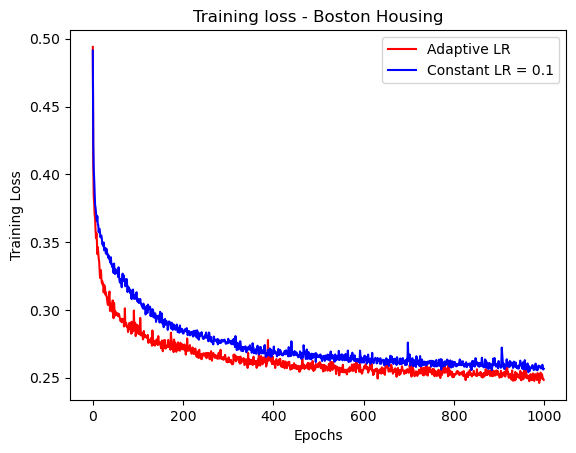

In [ ]:
loss_adaptive = history_lalr.history['loss']
loss_constant = history.history['loss']
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - Boston Housing')
plt.legend()

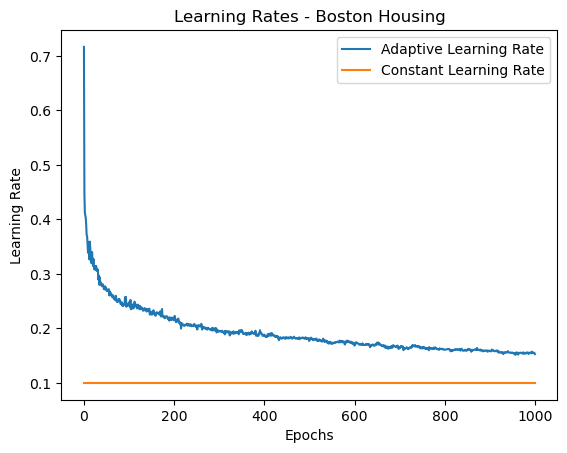

In [ ]:
plt.title('Learning Rates - Boston Housing')
plt.plot(epochs, lrs, label='Adaptive Learning Rate')
plt.plot(epochs, [0.1]*len(epochs), label ='Constant Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()